In [1]:
import keras
import tensorflow as tf
import numpy as np
np.random.seed(4)
import base64, os, json, glob, re, sys
from sklearn import preprocessing
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16, 5)
mpl.rcParams['axes.grid'] = False
pd.options.display.max_rows = 5
%matplotlib inline  

use_keras=2
if ( use_keras == 1):
    from keras.models import Sequential, Model
    from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, TimeDistributed
    from keras.layers import Conv1D, GlobalMaxPool1D,Flatten, Bidirectional, RepeatVector, MaxPooling1D
    from keras.preprocessing.sequence import TimeseriesGenerator
    from keras import regularizers
    from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, Callback
    from keras import optimizers
    from keras.models import load_model
elif ( use_keras == 0):
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, TimeDistributed
    from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D,Flatten, Bidirectional, RepeatVector, MaxPooling1D
    from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
    from tensorflow.keras import regularizers
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, Callback
    from tensorflow.keras import optimizers
    from tensorflow.keras.models import load_model
else:
    from keras.models import Sequential, Model
    from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, TimeDistributed
    from keras.layers import Conv1D, GlobalMaxPool1D,Flatten, Bidirectional, RepeatVector, MaxPooling1D
    from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
    from keras import regularizers
    from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, Callback
    from tensorflow.keras import optimizers
    from keras.models import load_model


Using TensorFlow backend.


In [2]:
file="data/stockdata.csv"
df1=pd.read_csv(file)
df=df1[['timestamp', 'MSFT_open', 'MSFT_high', 'MSFT_low', 'MSFT_close', 'MSFT_volume']].copy()
col='MSFT_open'
df[f'{col}_diff1'] = df[col] - df[col].shift(-1)
df.dropna(inplace=True)
df=df[:-50]
df=df.reindex(index=df.index[::-1])
df


,timestamp,MSFT_open,MSFT_high,MSFT_low,MSFT_close,MSFT_volume,MSFT_open_diff1
5193,2000-03-14,98.62,99.25,95.12,95.12,36744600.0,1.00
5192,2000-03-15,94.56,96.62,93.69,95.37,26604000.0,-4.06
...,...,...,...,...,...,...,...
1,2020-02-20,186.95,187.25,181.10,184.42,36862376.0,-1.11
0,2020-02-21,183.17,183.50,177.25,178.59,48438140.0,-3.78


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

train_count = int(0.8 * len(df))
standardScale = 1
if ( standardScale):
    scaler = StandardScaler()
    ltf = df[df.columns[1:]]
    dfs = scaler.fit(ltf[:train_count])
    ltf = (ltf-dfs.mean_)/dfs.scale_
else:
    scaler = preprocessing.MinMaxScaler()
    data = df[df.columns[1:]]
    ltf = scaler.fit_transform(data)
    ltf = pd.DataFrame(ltf)
    ltf.columns = df.columns[1:]

ltf.to_csv("data/stockdata_ext_prep.csv", index=False)
ltf

,MSFT_open,MSFT_high,MSFT_low,MSFT_close,MSFT_volume,MSFT_open_diff1
5193,4.301054,4.227410,4.175049,4.064056,-0.620817,1.065301
5192,4.022252,4.050424,4.074816,4.081238,-0.975837,-4.264919
...,...,...,...,...,...,...
1,10.366719,10.149352,10.201665,10.201384,-0.616694,-1.157380
0,10.107144,9.896997,9.931806,9.800705,-0.211429,-3.969966


In [6]:
tsParams = {'length': 50, 'batch_size': 1, 'stride': 1, 'sampling_rate': 1}
predsI=['MSFT_open', 'MSFT_high', 'MSFT_low', 'MSFT_close', 'MSFT_volume']
predsV=['MSFT_open', 'MSFT_open_diff1']
X = ltf[predsI].values
y = ltf[predsV].values
trng    = TimeseriesGenerator(X[:train_count], y[:train_count], **tsParams )
valg    = TimeseriesGenerator(X[train_count:], y[train_count:], **tsParams )
#X, y,  
ltf

,MSFT_open,MSFT_high,MSFT_low,MSFT_close,MSFT_volume,MSFT_open_diff1
5193,4.301054,4.227410,4.175049,4.064056,-0.620817,1.065301
5192,4.022252,4.050424,4.074816,4.081238,-0.975837,-4.264919
...,...,...,...,...,...,...
1,10.366719,10.149352,10.201665,10.201384,-0.616694,-1.157380
0,10.107144,9.896997,9.931806,9.800705,-0.211429,-3.969966


In [7]:
model1=None      

#sensN = len(self.train_transformed[0].columns)  # number of sensors (eliminating the two time ones)
#outN = len(self.num_id_list) # number of output sensors; the non-categorical ones        

lookBack   = tsParams['length']
nFeatures  = X.shape[1]  # Number of features 
lstm_OPDim = y.shape[1]  # This is usually all sensors except categorical that to train LSTM on
lstm_IPDim = 256
drop       = 0.3
optimizer  = optimizers.Adam(lr=0.0005)
loss       = 'mse'
k_rrizer   = None
r_rrizer   = None

input_layer  = Input(shape=(lookBack, nFeatures), dtype='float32', name='input')
memory_layer = LSTM( lstm_IPDim, return_sequences=True, name="memory1")(input_layer)
memory_layer = LSTM (int(lstm_IPDim/2), return_sequences=False, name="memory2")(memory_layer)
repeated     = RepeatVector(lookBack)(memory_layer)
memory_layer = LSTM (int(lstm_IPDim/2), return_sequences=True, name="first1out")(repeated)
memory_layer = LSTM (lstm_IPDim,  return_sequences=True, name="first2out")(memory_layer)
decoded_inputs = TimeDistributed(Dense(units=lstm_OPDim, activation='linear'))( memory_layer)

#  Try spatial dropout?
dropout_input = Dropout(drop)(input_layer)
concat_layer  = concatenate([dropout_input, decoded_inputs])

#memory_layer = LSTM (units=self.lstm_dim, return_sequences=False)(concat_layer)
memory_layer = LSTM (units=lstm_IPDim, 
                         kernel_regularizer = k_rrizer, 
                         recurrent_regularizer = r_rrizer, 
                         return_sequences=False)(concat_layer)
preds = Dense(units=lstm_OPDim, activation='linear')(memory_layer)

model1 = Model(input_layer, preds)
model1.compile(optimizer = optimizer, loss= loss)             

print(model1.summary())


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 50, 5)        0                                            
__________________________________________________________________________________________________
memory1 (LSTM)                  (None, 50, 256)      268288      input[0][0]                      
__________________________________________________________________________________________________
memory2 (LSTM)                  (None, 128)          197120      memory1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)  (None, 50, 128)      0           memory2[0][0]                    
____________________________________________________________________________________________

In [8]:
from keras.callbacks import Callback
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        self.current = np.inf
        self.best    = self.current

    def on_epoch_end(self, epoch, logs={}):
        self.current = logs.get(self.monitor)
        self.best    = min(self.best, self.current)
        
        if self.current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if self.current < self.value:
            if self.verbose > 0:
                print(f"Epoch:SADA {epoch}: early stopping THR: loss {self.current:10.7}")
            self.model.stop_training = True
            
est= EarlyStoppingByLossVal(monitor='val_loss', value=0.0000001, verbose=1)

In [9]:
cp = ModelCheckpoint(filepath="stockpredictions.h5", monitor='val_loss', save_best_only=True, verbose=1)
tb = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True,  write_images=True)


In [10]:
load_weights=0
if ( load_weights and os.path.exists("stockpredictions.h5")):
    model1.load_weights("stockpredictions.h5")
    model1.fit(trng, verbose=1, epochs=1, validation_data=valg,steps_per_epoch=1,
                   validation_steps=50, callbacks=[est])
    #cp.best = est.best
    print(cp.best, est.best, est.current)

In [11]:
model1.fit(trng, verbose=1, epochs=10, validation_data=valg, steps_per_epoch=200, 
                validation_steps=50, workers=4, use_multiprocessing=True, callbacks=[])    

Epoch 1/10
200/200 [==============================] - 17s 87ms/step - loss: 0.3071 - val_loss: 0.1473
Epoch 2/10
200/200 [==============================] - 23s 113ms/step - loss: 0.3525 - val_loss: 0.0145
Epoch 3/10
200/200 [==============================] - 23s 117ms/step - loss: 0.3861 - val_loss: 0.1652
Epoch 4/10
200/200 [==============================] - 23s 116ms/step - loss: 0.4225 - val_loss: 0.0120
Epoch 5/10
200/200 [==============================] - 23s 117ms/step - loss: 0.3278 - val_loss: 0.0599
Epoch 6/10
200/200 [==============================] - 23s 116ms/step - loss: 0.2846 - val_loss: 0.0597
Epoch 7/10
200/200 [==============================] - 23s 116ms/step - loss: 0.3205 - val_loss: 0.0570
Epoch 8/10
200/200 [==============================] - 24s 118ms/step - loss: 0.3963 - val_loss: 0.2585
Epoch 9/10
200/200 [==============================] - 23s 116ms/step - loss: 0.7033 - val_loss: 0.6343
Epoch 10/10
200/200 [==============================] - 23s 117ms/step - lo

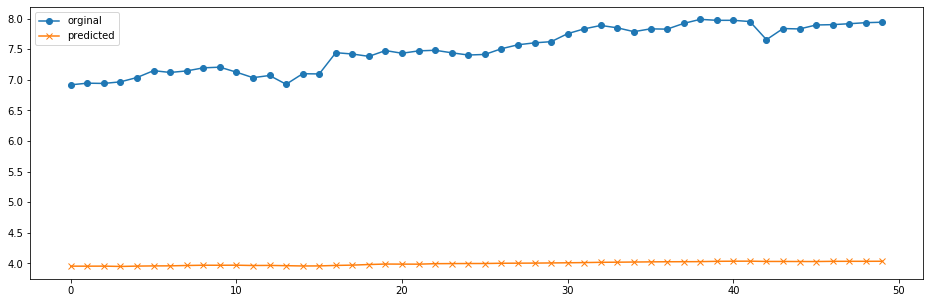

'plt.plot(yo[:,1][f:f + howmany], marker=\'o\', label="orginal", )\nplt.plot(yp[:,1][f:f + howmany], marker=\'x\', label="predicted")\nplt.legend()\nplt.show()'

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (16, 5)
mpl.rcParams['axes.grid'] = False

yp = model1.predict(valg)
#y = ndf[1:][predsV].values
yo= list(valg[0][1])
for i in range(1,len(valg)):
    yo += list(valg[i][1])
yo=np.array(yo)

f, howmany = -100, 50

plt.plot(yo[:,0][f:f + howmany], marker='o', label="orginal", )
plt.plot(yp[:,0][f:f + howmany], marker='x', label="predicted")
plt.legend()
plt.show()

'''plt.plot(yo[:,1][f:f + howmany], marker='o', label="orginal", )
plt.plot(yp[:,1][f:f + howmany], marker='x', label="predicted")
plt.legend()
plt.show()'''